<a href="https://colab.research.google.com/github/ZeXuan0512/Weather-Advisor/blob/main/Weather_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Configuration

In [2]:
!pip install python-dotenv

In [29]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import logging
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.cm as cm
import spacy
import re

In [4]:
# --- Upload env to colab ---
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    uploaded = files.upload()  # This opens the file picker in Colab
else:
    print(".env file must be placed in the same directory when running locally.")

Saving .env to .env


In [30]:
load_dotenv(".env")

# Load NLP model once
nlp = spacy.load("en_core_web_sm")

# Weather Data Functions

In [6]:
cache = {}

def get_weather_data(location, forecast_days=5):
    current_time = time.time()
    cache_key = f"{location}-{forecast_days}"

    # Check if data is cached and not expired (valid for 10 minutes)
    if cache_key in cache and current_time - cache[cache_key]['timestamp'] < 600:
        return cache[cache_key]['data']

    # Initialize the output data structure
    parsed_data = {
        "current": [],
        "forecast": []
    }

    try:
        # --- API Call Setup ---
        url = "http://api.weatherapi.com/v1/forecast.json"
        api_key = os.getenv("WEATHER_API_KEY")
        params = {
            "q": location,
            "key": api_key,
            "days": forecast_days
        }
        resp = requests.get(url, params=params)

        # --- Check API response ---
        if resp.status_code == 200:
            try:
                # Parse the response only once
                response_data = resp.json()

                # Process current weather data
                current_data = response_data.get("current", {})
                if current_data:
                    parsed_data["current"].append({
                        "datetime": current_data.get("last_updated", "N/A"),
                        "weather condition": current_data.get("condition", {}).get("text", "N/A"),
                        "temperature": current_data.get("temp_c", "N/A"),
                        "wind speed": current_data.get("wind_kph", "N/A"),
                        "humidity": current_data.get("humidity", "N/A"),
                        "feelslike_c": current_data.get("feelslike_c", "N/A"),
                        "precipitation": current_data.get("precip_mm", "N/A"),
                    })

                # Process forecast data
                forecast_data = response_data.get("forecast", {}).get("forecastday", [])
                for item in forecast_data:
                    parsed_data["forecast"].append({
                        "datetime": item.get("date", "N/A"),
                        "weather condition": item.get("day", {}).get("condition", {}).get("text", "N/A"),
                        "temperature": item.get("day", {}).get("avgtemp_c", "N/A"),
                        "wind speed": item.get("day", {}).get("maxwind_kph", "N/A"),
                        "humidity": item.get("day", {}).get("avghumidity", "N/A"),
                        "rain percentage": item.get("day", {}).get("daily_chance_of_rain", "N/A"),
                        "precipitation": item.get("day", {}).get('totalprecip_mm', "N/A")
                    })

                # Save to cache only after successful processing
                cache[cache_key] = {
                    'data': parsed_data,
                    'timestamp': current_time
                }
                return parsed_data

            except (KeyError, TypeError) as e:
                error_message = f"Data parsing error: {str(e)}"
                logging.error(error_message)
                return {"error": error_message}

        else:
            # Log the error response
            error_msg = resp.json().get("message", "No message provided")
            logging.error(f"Error {resp.status_code}: {error_msg}")
            return {"error": f"API Error {resp.status_code}: {error_msg}"}

    except requests.RequestException as e:
        logging.error(f"Network error: {str(e)}")
        return {"error": f"Network error: {str(e)}"}

In [11]:
test_data = get_weather_data("Penang", forecast_days=5)
current_df = pd.DataFrame(test_data["current"])
forecast_df = pd.DataFrame(test_data["forecast"])

In [20]:
current_df

,datetime,weather condition,temperature,wind speed,humidity,feelslike_c,precipitation
0,2025-05-07 16:45,Patchy rain nearby,31.4,12.2,71,38.3,0.03


In [21]:
forecast_df

,datetime,weather condition,temperature,wind speed,humidity,rain percentage,precipitation
0,2025-05-07,Patchy rain nearby,28.1,13.7,76,89,4.4


# Visualisation Functions


In [15]:
def create_temperature_visualisation(weather_data, output_type='display'):
    # Step 1: Extract forecast dates and temperatures efficiently
    try:
        dates = [datetime.strptime(item['datetime'], "%Y-%m-%d") for item in weather_data["forecast"]]
        temperatures = [item['temperature'] for item in weather_data["forecast"]]

        # Step 2: Create the line graph
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(dates, temperatures, marker='o', linestyle='-', color='blue', label='Forecast Temperature (°C)')

        # Format date on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)

        # Step 3: Set graph title and labels
        ax.set_title("Daily Temperature")
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        ax.grid(True)

        # Step 4: Rotate x-ticks for better readability
        plt.xticks(rotation=45)

        # Step 5: Output the visualisation
        if output_type == 'figure':
            plt.close(fig)
            return fig
        else:
            plt.show()
            plt.close(fig)

    except KeyError as e:
        print(f"Missing key in weather data: {e}")
    except Exception as e:
        print(f"Error while generating the graph: {e}")

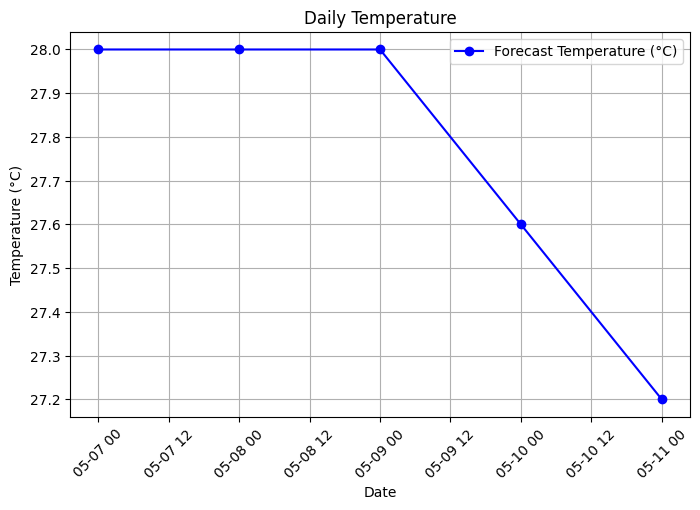

In [12]:
create_temperature_visualisation(test_data, output_type='display')

In [24]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    try:
        # Step 1: Extract forecast dates and precipitation amounts
        dates = [datetime.strptime(item['datetime'], "%Y-%m-%d") for item in weather_data["forecast"]]
        precipitation = [item['precipitation'] for item in weather_data["forecast"]]

        # Step 2: Normalize precipitation values for color mapping
        norm = plt.Normalize(min(precipitation), max(precipitation))
        colors = cm.Blues(norm(precipitation))  # Use 'Blues' colormap for a gradient effect

        # Step 3: Create the bar graph with a gradient color scheme
        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(dates, precipitation, color=colors, label='Precipitation (mm)')

        # Step 4: Set graph title and labels
        ax.set_title("Forecast Precipitation Trend")
        ax.set_xlabel("Date")
        ax.set_ylabel("Precipitation (mm)")
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Step 5: Format x-axis to display dates only (one per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())  # One tick per day
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD
        plt.xticks(rotation=45)  # Rotate for better readability

        # Step 6: Add colorbar to indicate precipitation intensity
        sm = cm.ScalarMappable(cmap='Blues', norm=norm)
        sm.set_array([])  # Empty array for colorbar
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Precipitation Intensity (mm)")

        # Step 7: Output the visualisation
        if output_type == 'figure':
            plt.close(fig)
            return fig
        else:
            plt.show()
            plt.close(fig)

    except KeyError as e:
        print(f"Missing key in weather data: {e}")
    except Exception as e:
        print(f"Error while generating the graph: {e}")


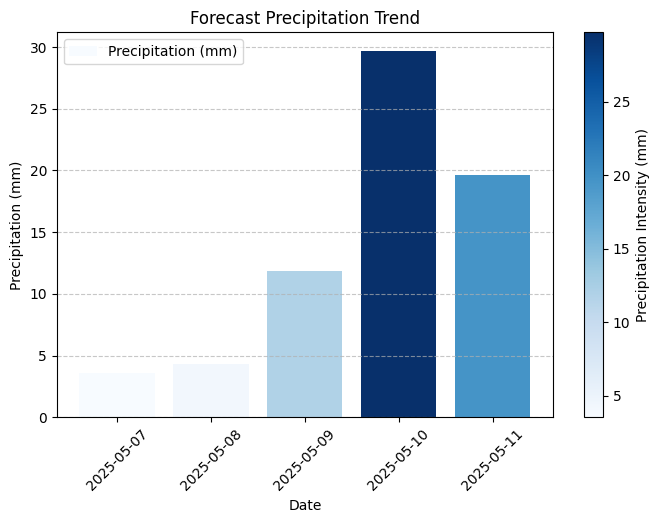

In [25]:
create_precipitation_visualisation(test_data, output_type='display')

# Natural Language Processing

In [26]:
def parse_weather_question(question):
    # Step 1: Initialize default values
    location = None
    days = None
    attribute = None

    # Step 2: Define synonyms for weather attributes
    attribute_keywords = {
        "temperature": ["temperature", "hot", "cold", "warm"],
        "humidity": ["humidity", "humid"],
        "wind speed": ["wind", "windy"],
        "chance of rain": ["rain", "raining", "rainy"],
        "sunny": ["sunny", "not raining", "not rainy"],
        "weather condition": ["weather", "forecast", "weather condition"],
        "precipitation": ["precipitation", "rainfall", "rain in mm"]
    }

    # Step 3: Process the question with the NLP model
    doc = nlp(question)

    # Step 4: Extract location using Named Entity Recognition (NER)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            location = ent.text
            break

    # Fallback: Check noun chunks for proper nouns (if no GPE found)
    if not location:
        for chunk in doc.noun_chunks:
            if chunk.root.pos_ == 'PROPN':
                location = chunk.text
                break

    # Step 5: Extract weather attribute using keyword matching
    for token in doc:
        for attr, keywords in attribute_keywords.items():
            if token.lemma_ in keywords:
                attribute = attr
                break
        if attribute:
            break

    # Step 6: Extract days from the question (based on common phrases)
    q_lower = question.lower()
    if "now" in q_lower:
        days = -1
    elif "today" in q_lower or "later" in q_lower:
        days = 0
    elif "tomorrow" in q_lower or "next day" in q_lower:
        days = 1
    elif match := re.search(r"next (\d+) days", q_lower):
        days = int(match.group(1))
    elif match := re.search(r"in (\d+) days", q_lower):
        days = int(match.group(1))

    # Step 7: Return the structured result
    return {
        "location": location,
        "days": days,
        "attribute": attribute
    }


In [31]:
test_parsed_questions = parse_weather_question("What is Kuala Lumpur temperature in next 4 days")
print(test_parsed_questions)

{'location': 'Kuala Lumpur', 'days': 4, 'attribute': 'temperature'}


In [32]:
def generate_weather_response(parsed_question, weather_data):
    location = parsed_question.get("location", "the location")
    days = parsed_question.get("days", 1)
    attribute = parsed_question.get("attribute", "weather")

    # Choose current data or forecast
    if days == -1:
        if "current" in weather_data and weather_data["current"]:
            data = weather_data["current"][0]
        else:
            return f"Sorry, I couldn't retrieve current weather data for {location}."
    else:
        if "forecast" in weather_data and weather_data["forecast"]:
            data = weather_data["forecast"]
        else:
            return f"Sorry, I couldn't retrieve forecast data for {location}."
    response = f"The {attribute} in {location} "
    for item in data:
        # Format responses based on attribute
        if attribute == "temperature":
            response += f"at {item['datetime']} is around {item['temperature']}°C "
        elif attribute == "humidity":
            response += f"at {item['datetime']} is {item['humidity']}% "
        elif attribute == "wind speed":
            response += f"at {item['datetime']} is {item['wind speed']}km/h "
        elif attribute == "chance of rain" and days != -1:
            if data['rain_percentage'] > 50:
              response += f"at {item['datetime']} is {item['rain percentage']}% "
            else:
              response += f"at {item['datetime']} is {item['rain percentage']}% "
        elif attribute == "sunny" and days != -1:
            if data['rain percentage'] > 50:
              return f"Yes, it will be a sunny day"
            else:
              return f"No, it might be rain."
        elif attribute == "weather":
            response += f"at {item['datetime']} is {item['weather condition']} "
        else:
            return f"Please restructure your sentence."

    return response


In [33]:
print(generate_weather_response(test_parsed_questions, test_data))

The temperature in Kuala Lumpur at 2025-05-07 is around 28.0°C at 2025-05-08 is around 28.0°C at 2025-05-09 is around 28.0°C at 2025-05-10 is around 27.6°C at 2025-05-11 is around 27.2°C 
